In [ ]:
import torch
import pdb # python debugger, for debugging
from torch.utils.data import DataLoader # for loading dataset as batches
from torch import nn # each class, a nn.module
from torchvision import transforms
from torchvision.datasets import MNIST # handwritten digits dataset
from torchvision.utils import make_grid # make grid of images, which can be passed directly to plplot for showing
from tqdm.auto import tqdm # for showing nice progress bar ui for training
import matplotlib.pyplot as plt # for showing real/predicted images

## Utility to show images (real/predicted)

Function takes num images and arranges them on square grid, which then will be showed by plt.imshow()

tensor.detach() -> will detach tensor from gradient calculations

.cpu() -> will copy back to cpu from gpu, so that plt can access

.view() -> conevrts tensor into new dimensions, here 3-tensor with dimensions(whatever_remaining, channels, 28, 28)

make_grid() -> takes num tensors and arranges them in nrow grid cells

.permute() ->  plt assumes channels are at end, so rearranging

plt.imshow() -> pass grid, plt will show as images in grid

In [ ]:
def show(tensor, ch=1, size=(28, 28), num=16):
  # tensor : 128 x 784
  data = tensor.detach().cpu().view(-1, ch, *size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

## Parameters Setup

In [ ]:
# hyperparameters setup

epochs = 500
current_step = 0
info_step = 300 # at each info_step, information is printed to screen
mean_generator_loss = 0 # mean loss of generator model
mean_discriminator_loss = 0 # mean loss of discriminator model

z_dim = 64 # input dimenions to generator
learning_rate = 0.00001 # this value is best for adam
loss_func = nn.BCEWithLogitsLoss() # logits enable numerical stability by directly calculating losses in one equation

batch_size = 128 # this many examples are sent to network at once, 128 * (input_image_size_flattned_out)
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# download dataset to ccurrent path and transforming to tensor. Internally arranges data with 128 batchsize
dataloader = DataLoader(MNIST('.', download=True, transform = transforms.ToTensor()), shuffle=True, batch_size=batch_size)

# total number of steps are going to be dataset_size / batch_size = 60000/128 = 468.75


100%|██████████| 9912422/9912422 [00:00<00:00, 92648030.96it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105980484.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25017422.75it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Generator Model

In [ ]:
def genBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.BatchNorm1d(output),
      nn.ReLU(inplace=True)
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=64, input_dimension=784, hidden_dimension=128):
    super().__init__()
    self.generator_model = nn.Sequential(
        genBlock(z_dim, hidden_dimension), # 64, 128
        genBlock(hidden_dimension, hidden_dimension * 2), # 128, 256
        genBlock(hidden_dimension * 2, hidden_dimension * 4), # 256, 512
        genBlock(hidden_dimension * 4, hidden_dimension * 8), # 512, 1024
        nn.Linear(hidden_dimension * 8, input_dimension), # 1024, 784
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.generator_model(noise)

In [ ]:
def genNoise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator Model

In [ ]:
def disBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_dimension=784, hidden_dimension=256):
    super().__init__()
    self.discriminator_model = nn.Sequential(
        disBlock(input_dimension, hidden_dimension * 4 ), # 784, 1024
        disBlock(hidden_dimension * 4, hidden_dimension * 2), # 1024, 512
        disBlock(hidden_dimension * 2, hidden_dimension), # 512, 256
        nn.Linear(hidden_dimension, 1) # 256, 1
    )

  def forward(self, image):
    return self.discriminator_model(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = learning_rate)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = learning_rate)

In [ ]:
gen

Generator(
  (generator_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (discriminator_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Loss Calculations

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([1, 5, 4, 7, 1, 5, 8, 1, 4, 6])
torch.Size([128, 64])
torch.Size([128, 784])


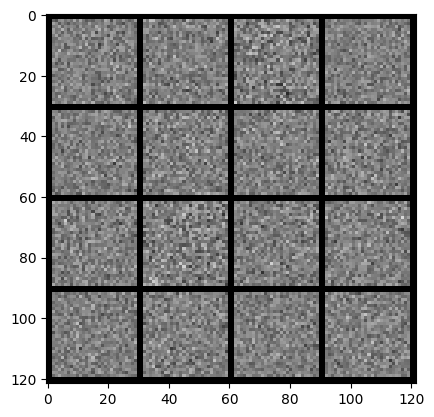

In [ ]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = genNoise(batch_size, z_dim)
print(noise.shape)
fake = gen(noise)
print(fake.shape)
show(fake)

### Generator Loss

In [ ]:
def calculate_generator_loss(loss_func, gen, disc, number, z_dim):
  noise = genNoise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)

  return gen_loss

### Discriminator Loss

In [ ]:
def calculate_discriminator_loss(loss_func, gen, disc, number, real, z_dim):
  noise = genNoise(number, z_dim)
  fake = gen(noise)
  disc_fake_pred = disc(fake)
  disc_fake_targets = torch.zeros_like(disc_fake_pred)
  disc_fake_loss = loss_func(disc_fake_pred, disc_fake_targets)

  disc_real_pred = disc(real)
  disc_real_targets = torch.ones_like(disc_real_pred)
  disc_real_loss = loss_func(disc_real_pred, disc_real_targets)

  disc_loss = ( disc_fake_loss + disc_real_loss ) / 2

  return disc_loss

## Training

In [ ]:
# 60000/128 = 468.75 = 469 steps in each epoch
# Each step process 128(batch_size) images at a time except last step

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    # discriminator
    disc_opt.zero_grad()

    curr_bs = len(real) # 128 x 1 x 28 x 28
    real = real.view(curr_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calculate_discriminator_loss(loss_func, gen, disc, curr_bs, real, z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    # generator
    gen_opt.zero_grad()

    gen_loss = calculate_generator_loss(loss_func, gen, disc, curr_bs, z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    # visualization & stats
    mean_discriminator_loss += disc_loss.item() / info_step
    mean_generator_loss += gen_loss.item()/ info_step

    if current_step % info_step == 0 and current_step > 0:
      fake_noise = genNoise(curr_bs, z_dim)
      fake = gen(fake_noise)

      show(fake)
      show(real)
      print(f"epoch : {epoch} , step : {current_step} / Gen Loss : {mean_generator_loss}, Dis loss : {mean_discriminator_loss}")
      mean_generator_loss, mean_discriminator_loss = 0,0

    current_step += 1



Output hidden; open in https://colab.research.google.com to view.

torch.Size([128, 64])
torch.Size([128, 784])


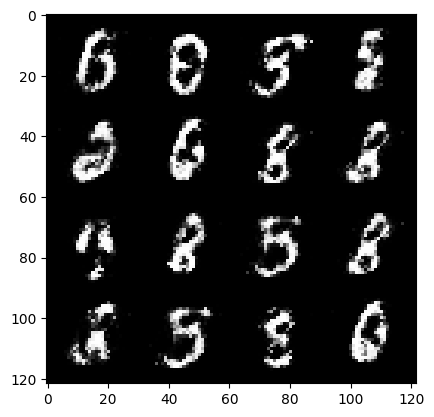

In [ ]:
noise = genNoise(batch_size, z_dim)
print(noise.shape)
fake = gen(noise)
print(fake.shape)
show(fake)

In [ ]:
torch.save(gen, "./gen_model")
torch.save(disc, "./disc_model")